In [ ]:
import numpy as np
import csv
import os
import glob
import pandas as pd
import math
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from tabulate import tabulate
from plotnine import *
import plotnine
from sklearn.metrics import confusion_matrix
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv('/content/drive/My Drive/combined_csv2.csv', delimiter=',', skipinitialspace=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (41,62,85) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df = pd.DataFrame(data)
df.columns = list(map(str.lower, data.columns.astype(str)))
target_col = 'label'
print(df.columns)

Index(['unnamed: 0', 'flow id', 'source ip', 'source port', 'destination ip',
       'destination port', 'protocol', 'timestamp', 'flow duration',
       'total fwd packets', 'total backward packets',
       'total length of fwd packets', 'total length of bwd packets',
       'fwd packet length max', 'fwd packet length min',
       'fwd packet length mean', 'fwd packet length std',
       'bwd packet length max', 'bwd packet length min',
       'bwd packet length mean', 'bwd packet length std', 'flow bytes/s',
       'flow packets/s', 'flow iat mean', 'flow iat std', 'flow iat max',
       'flow iat min', 'fwd iat total', 'fwd iat mean', 'fwd iat std',
       'fwd iat max', 'fwd iat min', 'bwd iat total', 'bwd iat mean',
       'bwd iat std', 'bwd iat max', 'bwd iat min', 'fwd psh flags',
       'bwd psh flags', 'fwd urg flags', 'bwd urg flags', 'fwd header length',
       'bwd header length', 'fwd packets/s', 'bwd packets/s',
       'min packet length', 'max packet length', 'packet le

In [ ]:
print(df.shape)
non_floats = []

#cleaning data from columns which have a non int/float type 
for col in df:
    if df[col].dtypes != "float64" and df[col].dtypes != "int64" and col != target_col:
        non_floats.append(col)
    elif df[col].dtypes == "int64":
        df[col] = df[col].astype(float)
df = df.drop(columns=non_floats)
df.info()
print(df.shape)

(59990, 88)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59990 entries, 0 to 59989
Data columns (total 81 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   unnamed: 0                   59990 non-null  float64
 1   source port                  59990 non-null  float64
 2   destination port             59990 non-null  float64
 3   protocol                     59990 non-null  float64
 4   flow duration                59990 non-null  float64
 5   total fwd packets            59990 non-null  float64
 6   total backward packets       59990 non-null  float64
 7   total length of fwd packets  59990 non-null  float64
 8   total length of bwd packets  59990 non-null  float64
 9   fwd packet length max        59990 non-null  float64
 10  fwd packet length min        59990 non-null  float64
 11  fwd packet length mean       59990 non-null  float64
 12  fwd packet length std        59990 non-null  float64
 13  bwd 

In [ ]:
#cleaning data from nan and infinite values
df =df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

#assigning binary values to our target column (binary classification)
df.loc[df[target_col] != 'BENIGN', target_col] = 1
df.loc[df[target_col] == 'BENIGN', target_col] = 0
print(df.head())

   unnamed: 0  source port  destination port  ...  idle min  inbound  label
0       425.0        634.0           60495.0  ...       0.0      1.0      1
1       430.0        634.0           60495.0  ...       0.0      0.0      1
2      1654.0        634.0           46391.0  ...       0.0      1.0      1
3      2927.0        634.0           11894.0  ...       0.0      1.0      1
4       694.0        634.0           27878.0  ...       0.0      1.0      1

[5 rows x 81 columns]


In [ ]:
X = df.iloc[:, 0:80]
y = df.iloc[:, 80]

# **Feature Selection**

### Feature selection using select k best

In [ ]:
selector = SelectKBest(f_classif, k = 40)
X_new = selector.fit_transform(X, y)

names = X.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)
ns_df_sorted.to_excel('binaryKbest.xlsx')

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [34 35 36 45 48 52 57 58 59 60 61 62] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


                 Feat_names       F_Scores
39                  inbound  116236.323817
31            down/up ratio   31834.036576
3                  protocol   30836.095409
1               source port   23838.686241
24        min packet length   17751.827550
6     fwd packet length min   17727.937943
9     bwd packet length min   17516.361153
33     avg fwd segment size   17501.811126
7    fwd packet length mean   17501.811126
29           urg flag count   16790.263332
23            fwd packets/s   16477.944569
13           flow packets/s   16290.848702
25       packet length mean   15120.689988
32      average packet size   14727.532095
5     fwd packet length max   11705.234263
12             flow bytes/s   10005.526385
2          destination port    9541.005487
34     avg bwd segment size    7142.234129
10   bwd packet length mean    7142.234129
30           cwe flag count    6826.413143
28           ack flag count    6246.859719
35   init_win_bytes_forward    5803.467585
4          

### Feature Selection using RFE and Random forest as it's method

In [ ]:
clf = RandomForestClassifier()
rfe = RFE(clf, n_features_to_select=40)
y = y.astype('int')
rfe.fit(X, y)

In [ ]:
print(rfe.support_)
print(rfe.ranking_)

[False  True  True  True  True False  True  True False  True  True  True
 False  True False False False  True  True  True  True  True False  True
 False  True  True False  True  True False  True False False False False
 False  True  True  True  True  True  True  True  True False False False
 False False  True False False  True  True  True False False False False
 False False False  True  True  True False  True  True False  True False
 False False False False False False False  True]
[17  1  1  1  1  3  1  1  9  1  1  1 21  1 10 12  4  1  1  1  1  1  5  1
  2  1  1 15  1  1 19  1 18 29 41 38 40  1  1  1  1  1  1  1  1 36 23 28
 32 11  1  7 37  1  1  1 13 31 39 30 33 34 35  1  1  1 14  1  1 22  1 16
 25  6  8 24 20 26 27  1]


In [ ]:
names = X.columns.values[rfe.get_support()]
scores = rfe.ranking_[rfe.get_support(indices = True)]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)
ns_df_sorted.to_excel('binaryRFE.xlsx')

In [ ]:
names = X.columns.values[rfe.get_support()]
scores = rfe.estimator_.feature_importances_
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)
ns_df_sorted.to_excel('binaryRFEscore.xlsx')

                     Feat_names  F_Scores
7         fwd packet length min  0.132466
24            min packet length  0.103343
32         avg fwd segment size  0.096691
8        fwd packet length mean  0.088117
39                      inbound  0.062347
31          average packet size  0.059262
38         min_seg_size_forward  0.041843
10                 flow bytes/s  0.041077
1              destination port  0.040494
26           packet length mean  0.039182
0                   source port  0.032853
35          subflow bwd packets  0.030033
23                bwd packets/s  0.027535
4        total backward packets  0.022400
21            bwd header length  0.017036
36       init_win_bytes_forward  0.016302
37      init_win_bytes_backward  0.015473
25            max packet length  0.015065
5   total length of fwd packets  0.014530
6         fwd packet length max  0.009531
27            packet length std  0.008057
18                bwd iat total  0.007927
29               urg flag count  0

In [ ]:
pd.DataFrame(rfe.support_,index=X.columns,columns=['important'])

,important
unnamed: 0,False
source port,True
destination port,True
protocol,True
flow duration,True
...,...
idle mean,False
idle std,False
idle max,False
idle min,False


### Feature Selection using Random forest 

In [ ]:
RF_model = RandomForestClassifier()
RF_model.fit(X,y)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
names = X.columns.values[rfe.get_support()]
scores = RF_model.feature_importances_
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)
ns_df_sorted.to_excel('binaryRF.xlsx')

                     Feat_names  F_Scores
11                 flow bytes/s  0.061032
10        bwd packet length max  0.056625
37      init_win_bytes_backward  0.050518
9        fwd packet length mean  0.047975
17                 fwd iat mean  0.036585
1              destination port  0.032213
31          average packet size  0.031625
7         fwd packet length max  0.023246
19                bwd iat total  0.022645
39                      inbound  0.020194
29               urg flag count  0.019613
28       packet length variance  0.019475
2                      protocol  0.018300
38         min_seg_size_forward  0.016339
18                  fwd iat max  0.011796
6   total length of fwd packets  0.011718
13                flow iat mean  0.008480
32         avg fwd segment size  0.006226
20                 bwd iat mean  0.005295
3                 flow duration  0.004903
4             total fwd packets  0.004711
23                bwd packets/s  0.003708
5        total backward packets  0

### Feature selection using RFE with Decision tree as estimator

In [ ]:
DT_clf = DecisionTreeClassifier()
rfe = RFE(DT_clf, n_features_to_select=40)
y = y.astype('int')
rfe.fit(X, y)

RFE(estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                     criterion='gini', max_depth=None,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     presort='deprecated', random_state=None,
                                     splitter='best'),
    n_features_to_select=40, step=1, verbose=0)

In [ ]:
names = X.columns.values[rfe.get_support()]
scores = rfe.ranking_[rfe.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)
ns_df_sorted.to_excel('binaryRFE_DT.xlsx')

In [ ]:
names = X.columns.values[rfe.get_support()]
scores = rfe.estimator_.feature_importances_
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)
ns_df_sorted.to_excel('binaryRFE_DTscore.xlsx')

                     Feat_names  F_Scores
10        fwd packet length min  0.747430
33         min_seg_size_forward  0.110986
13        bwd packet length min  0.075676
31      init_win_bytes_backward  0.031114
20               urg flag count  0.008837
34                   active min  0.005846
2              destination port  0.005129
29          subflow bwd packets  0.004589
32             act_data_pkt_fwd  0.002025
1                   source port  0.001636
30       init_win_bytes_forward  0.001428
17                 flow iat std  0.001314
15                 flow bytes/s  0.001106
39                      inbound  0.000721
5             total fwd packets  0.000602
16                flow iat mean  0.000514
0                    unnamed: 0  0.000474
4                 flow duration  0.000312
24          average packet size  0.000133
23                down/up ratio  0.000103
19                 flow iat min  0.000026
26         avg bwd segment size  0.000000
25         avg fwd segment size  0

# K-FOLD CROSS VALIDATION 

In [ ]:
#features kept by the Random forest features selection
colums_to_keep = ['flow packets/s', 'flow iat mean', 'flow bytes/s', 'fwd packet length min', 'init_win_bytes_backward', 'fwd iat std', 'flow duration',
 'inbound', 'average packet size', 'destination port', 'fwd packet length mean', 'min_seg_size_forward', 'fwd iat max',
 'packet length std', 'bwd iat max', 'bwd packet length max', 'packet length variance', 'total backward packets',
 'bwd iat mean','fwd iat total', 'bwd iat total', 'total length of fwd packets', 'flow iat max', 'max packet length', 
 'flow iat std', 'fwd packets/s', 'fwd packet length max', 'bwd packets/s', 'bwd header length', 'packet length mean',
 'flow iat min', 'urg flag count', 'fwd iat mean', 'min packet length', 'source port', 'avg fwd segment size', 'subflow fwd packets',
 'init_win_bytes_forward', 'subflow bwd packets', 'subflow fwd bytes', 'label']

df_filtered = df.reindex(columns = colums_to_keep)

df_filtered['label'] = df_filtered['label'].astype(int)
print(df_filtered.shape)
print(df_filtered.dtypes)

df_filtered.head()

(59304, 41)
flow packets/s                 float64
flow iat mean                  float64
flow bytes/s                   float64
fwd packet length min          float64
init_win_bytes_backward        float64
fwd iat std                    float64
flow duration                  float64
inbound                        float64
average packet size            float64
destination port               float64
fwd packet length mean         float64
min_seg_size_forward           float64
fwd iat max                    float64
packet length std              float64
bwd iat max                    float64
bwd packet length max          float64
packet length variance         float64
total backward packets         float64
bwd iat mean                   float64
fwd iat total                  float64
bwd iat total                  float64
total length of fwd packets    float64
flow iat max                   float64
max packet length              float64
flow iat std                   float64
fwd packets/s

,flow packets/s,flow iat mean,flow bytes/s,fwd packet length min,init_win_bytes_backward,fwd iat std,flow duration,inbound,average packet size,destination port,fwd packet length mean,min_seg_size_forward,fwd iat max,packet length std,bwd iat max,bwd packet length max,packet length variance,total backward packets,bwd iat mean,fwd iat total,bwd iat total,total length of fwd packets,flow iat max,max packet length,flow iat std,fwd packets/s,fwd packet length max,bwd packets/s,bwd header length,packet length mean,flow iat min,urg flag count,fwd iat mean,min packet length,source port,avg fwd segment size,subflow fwd packets,init_win_bytes_forward,subflow bwd packets,subflow fwd bytes,label
0,3413.689952,295.989583,1.502024e+06,440.0,-1.0,500.959301,28415.0,1.0,444.536082,60495.0,440.0,-1.0,3596.0,0.0,0.0,0.0,0.0,0.0,0.0,28415.0,0.0,42680.0,3596.0,440.0,500.959301,3413.689952,440.0,0.0,0.0,440.0,1.0,0.0,295.989583,440.0,634.0,440.0,97.0,-1.0,0.0,42680.0,1
1,1000000.000000,2.000000,4.400000e+08,440.0,-1.0,0.000000,2.0,0.0,660.000000,60495.0,440.0,-1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,880.0,2.0,440.0,0.000000,1000000.000000,440.0,0.0,0.0,440.0,2.0,0.0,2.000000,440.0,634.0,440.0,2.0,-1.0,0.0,880.0,1
2,4119.549321,243.964824,1.812602e+06,440.0,-1.0,578.101371,48549.0,1.0,442.200000,46391.0,440.0,-1.0,5418.0,0.0,0.0,0.0,0.0,0.0,0.0,48549.0,0.0,88000.0,5418.0,440.0,578.101371,4119.549321,440.0,0.0,0.0,440.0,1.0,0.0,243.964824,440.0,634.0,440.0,200.0,-1.0,0.0,88000.0,1
3,4137.617146,242.899497,1.820552e+06,440.0,-1.0,485.292695,48337.0,1.0,442.200000,11894.0,440.0,-1.0,3337.0,0.0,0.0,0.0,0.0,0.0,0.0,48337.0,0.0,88000.0,3337.0,440.0,485.292695,4137.617146,440.0,0.0,0.0,440.0,1.0,0.0,242.899497,440.0,634.0,440.0,200.0,-1.0,0.0,88000.0,1
4,6244.925998,160.934673,2.747767e+06,440.0,-1.0,196.891271,32026.0,1.0,442.200000,27878.0,440.0,-1.0,1236.0,0.0,0.0,0.0,0.0,0.0,0.0,32026.0,0.0,88000.0,1236.0,440.0,196.891271,6244.925998,440.0,0.0,0.0,440.0,0.0,0.0,160.934673,440.0,634.0,440.0,200.0,-1.0,0.0,88000.0,1


In [ ]:
X = df_filtered.iloc[:, 0:40]
y = df_filtered.iloc[:, 40]

### Logisitic Regression 

In [ ]:
k = 5
kf = KFold(n_splits=k, random_state= 0)
model = LogisticRegression(solver= 'liblinear')
acc_score = []
f1_sc = []
precision_sc = []
recall_sc = []
specificity_sc = []
auc_sc = []
g_mean_sc = []

for train_index , test_index in kf.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)

  X_train , X_test = X.iloc[train_index,0:40],X.iloc[test_index,0:40]
  y_train , y_test = y.iloc[train_index], y.iloc[test_index]
     
  model.fit(X_train,y_train)
  pred_values = model.predict(X_test)
     
  acc = accuracy_score(pred_values , y_test)   #accuracy
  f1 = f1_score(pred_values, y_test)            #f1
  rec = recall_score(pred_values, y_test)     #recall
  prec = precision_score(pred_values, y_test) #precision
  tn, fp, fn, tp = confusion_matrix(y_test, pred_values).ravel()
  specificity = tn / (tn+fp)   #specificity
  fpr, tpr, thresholds = roc_curve(y_test, pred_values, drop_intermediate = False)
  gmean = math.sqrt(rec * specificity)   #geometric mean
  area_u_c = auc(fpr, tpr)               #Area under the curve

  acc_score.append(acc)
  f1_sc.append(f1)
  recall_sc.append(rec)
  precision_sc.append(prec)
  specificity_sc.append(specificity)
  auc_sc.append(area_u_c)
  g_mean_sc.append(gmean)

avg_acc_score = sum(acc_score)/k
avg_f1_sc = sum(f1_sc)/k
avg_recall_sc = sum(recall_sc)/k
avg_precision_sc = sum(precision_sc)/k
avg_specificity_sc = sum(specificity_sc)/k
avg_auc_sc = sum(auc_sc)/k
avg_g_mean_sc = sum(g_mean_sc)/k

 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}\n'.format(avg_acc_score))

print('f1 score of each fold - {}'.format(f1_sc))
print('Avg f1 score : {}\n'.format(avg_f1_sc))

print('recall of each fold - {}'.format(recall_sc))
print('Avg recall : {}\n'.format(avg_recall_sc))

print('precision of each fold - {}'.format(precision_sc))
print('Avg precision : {}\n'.format(avg_precision_sc))

print('precision of each fold - {}'.format(precision_sc))
print('Avg precision : {}\n'.format(avg_precision_sc))

print('specificity of each fold - {}'.format(specificity_sc))
print('Avg specificity : {}\n'.format(avg_specificity_sc))

print('auc of each fold - {}'.format(auc_sc))
print('Avg auc : {}\n'.format(avg_auc_sc))

print('gmean of each fold - {}'.format(g_mean_sc))
print('Avg gmean : {}\n'.format(avg_g_mean_sc))


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy of each fold - [0.9453671697158755, 0.9994941404603321, 0.9984824213809965, 0.8431835427029761, 0.9598650927487352]
Avg accuracy : 0.9492784734017832

f1 score of each fold - [0.9696827921774119, 0.999746963562753, 0.9992401215805471, 0.8264925373134329, 0.9771855828220858]
Avg f1 score : 0.9544695994912462

recall of each fold - [0.9978815599422244, 1.0, 0.9998310382698319, 0.8058941240676732, 0.9848323833446044]
Avg recall : 0.957687821124867

precision of each fold - [0.9430339430339431, 0.9994940551479888, 0.9986499029617754, 0.8481715489182462, 0.9696566156187577]
Avg precision : 0.9518012131361422

precision of each fold - [0.9430339430339431, 0.9994940551479888, 0.9986499029617754, 0.8481715489182462, 0.9696566156187577]
Avg precision : 0.9518012131361422

specificity of each fold - [0.9747706422018348, 1.0, 0.8, 0.8392588128954505, 0.8834446919079436]
Avg specificity : 0.8994948294010457

auc of each fold - [0.958902292617889, 0.9997470275739944, 0.8993249514808878, 0.

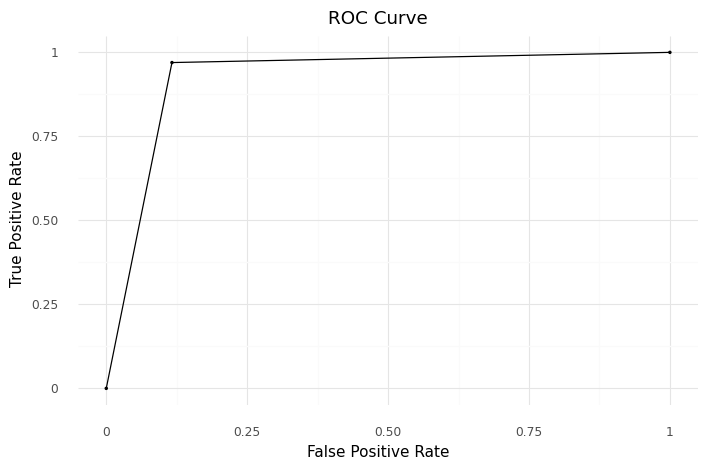

<ggplot: (8757253293621)>

In [ ]:
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
df_fpr_tpr.head()


plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate')+
    ylab('True Positive Rate')+
    theme_minimal()
)

Best Threshold: 1 with G-Mean: 0.9255
FPR: 0.1166, TPR: 0.9697


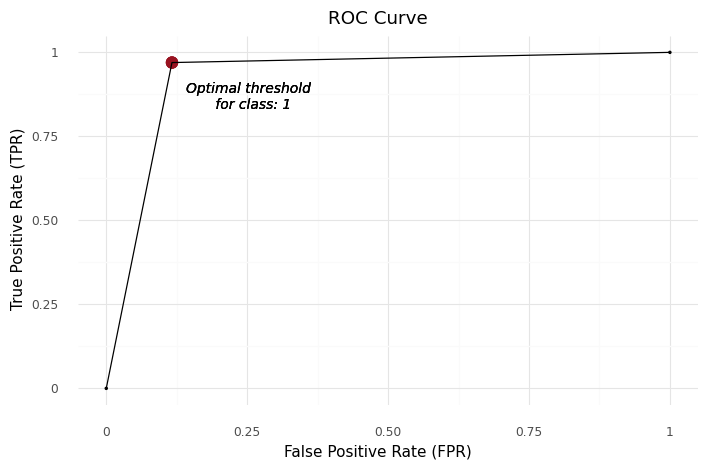

<ggplot: (8757253122769)>

In [ ]:
# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

In [ ]:
print(pred_values)

[0 1 0 ... 1 1 1]


### Support Vector Machines

In [ ]:
k = 5
kf = KFold(n_splits=k, random_state= 0)
model = svm.LinearSVC()
acc_score = []
f1_sc = []
precision_sc = []
recall_sc = []
specificity_sc = []
auc_sc = []
g_mean_sc = []

for train_index , test_index in kf.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)

  X_train , X_test = X.iloc[train_index,0:40],X.iloc[test_index,0:40]
  y_train , y_test = y.iloc[train_index], y.iloc[test_index]
     
  model.fit(X_train,y_train)
  pred_values = model.predict(X_test)
     
  acc = accuracy_score(pred_values , y_test)   #accuracy
  f1 = f1_score(pred_values, y_test)            #f1
  rec = recall_score(pred_values, y_test)     #recall
  prec = precision_score(pred_values, y_test)  #precision
  tn, fp, fn, tp = confusion_matrix(y_test, pred_values).ravel()
  specificity = tn / (tn+fp)   #specificity
  fpr, tpr, thresholds = roc_curve(y_test, pred_values, drop_intermediate = False)
  gmean = math.sqrt(rec * specificity)   #geometric mean
  area_u_c = auc(fpr, tpr)               #Area under the curve

  acc_score.append(acc)
  f1_sc.append(f1)
  recall_sc.append(rec)
  precision_sc.append(prec)
  specificity_sc.append(specificity)
  auc_sc.append(area_u_c)
  g_mean_sc.append(gmean)

avg_acc_score = sum(acc_score)/k
avg_f1_sc = sum(f1_sc)/k
avg_recall_sc = sum(recall_sc)/k
avg_precision_sc = sum(precision_sc)/k
avg_specificity_sc = sum(specificity_sc)/k
avg_auc_sc = sum(auc_sc)/k
avg_g_mean_sc = sum(g_mean_sc)/k

 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}\n'.format(avg_acc_score))

print('f1 score of each fold - {}'.format(f1_sc))
print('Avg f1 score : {}\n'.format(avg_f1_sc))

print('recall of each fold - {}'.format(recall_sc))
print('Avg recall : {}\n'.format(avg_recall_sc))

print('precision of each fold - {}'.format(precision_sc))
print('Avg precision : {}\n'.format(avg_precision_sc))

print('precision of each fold - {}'.format(precision_sc))
print('Avg precision : {}\n'.format(avg_precision_sc))

print('specificity of each fold - {}'.format(specificity_sc))
print('Avg specificity : {}\n'.format(avg_specificity_sc))

print('auc of each fold - {}'.format(auc_sc))
print('Avg auc : {}\n'.format(avg_auc_sc))

print('gmean of each fold - {}'.format(g_mean_sc))
print('Avg gmean : {}\n'.format(avg_g_mean_sc))


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, incr

accuracy of each fold - [0.38285136160526095, 0.91611162633842, 0.7321473737458899, 0.5540848157828177, 0.8846543001686341]
Avg accuracy : 0.6939698955282045

f1 score of each fold - [0.511283215382561, 0.9562156215621561, 0.8452131546894033, 0.22140438686883554, 0.9326041974578776]
Avg f1 score : 0.6933441151921667

recall of each fold - [0.959889696665831, 0.999907969814099, 1.0, 0.4789808917197452, 0.9672968829841594]
Avg recall : 0.881215088236767

precision of each fold - [0.34843934843934843, 0.916181802850156, 0.7319213568475235, 0.14397855638521923, 0.9003138970798059]
Avg precision : 0.6081669923204107

precision of each fold - [0.34843934843934843, 0.916181802850156, 0.7319213568475235, 0.14397855638521923, 0.9003138970798059]
Avg precision : 0.6081669923204107

specificity of each fold - [0.8165137614678899, 0.5, 1.0, 0.8767701114793612, 0.7624350408314774]
Avg specificity : 0.7911437827557457

auc of each fold - [0.5824765549536192, 0.708090901425078, 0.8659606784237617, 0.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


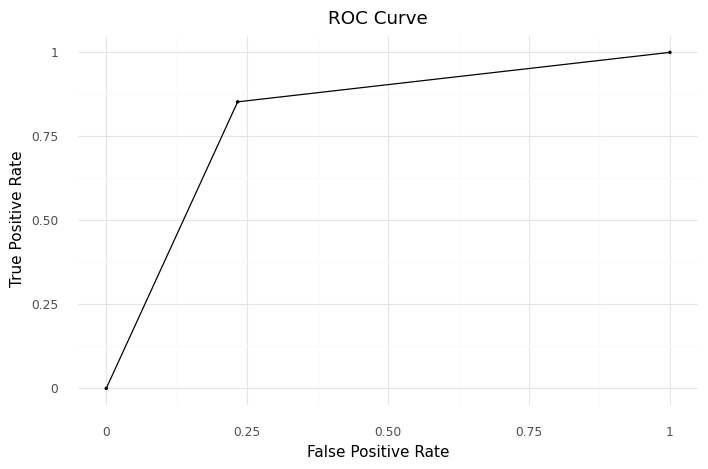

<ggplot: (8757253182177)>

In [ ]:
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
df_fpr_tpr.head()

plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate')+
    ylab('True Positive Rate')+
    theme_minimal()
)

Best Threshold: 1 with G-Mean: 0.8087
FPR: 0.2331, TPR: 0.8528


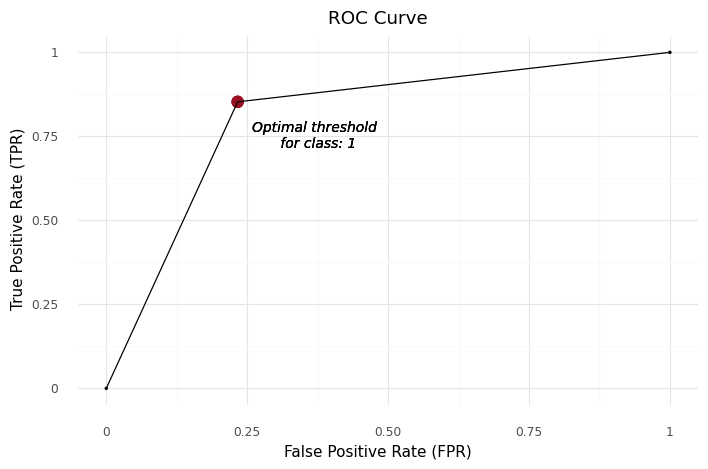

<ggplot: (8757253149925)>

In [ ]:
# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

### Random Forests

In [ ]:
k = 5
kf = KFold(n_splits=k, random_state= 0)
model = RandomForestClassifier()
acc_score = []
f1_sc = []
precision_sc = []
recall_sc = []
specificity_sc = []
auc_sc = []
g_mean_sc = []

for train_index , test_index in kf.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)

  X_train , X_test = X.iloc[train_index,0:40],X.iloc[test_index,0:40]
  y_train , y_test = y.iloc[train_index], y.iloc[test_index]
     
  model.fit(X_train,y_train)
  pred_values = model.predict(X_test)
     
  acc = accuracy_score(pred_values , y_test)   #accuracy
  f1 = f1_score(pred_values, y_test)            #f1
  rec = recall_score(pred_values, y_test)      #recall
  prec = precision_score(pred_values, y_test)  #precision
  tn, fp, fn, tp = confusion_matrix(y_test, pred_values).ravel()
  specificity = tn / (tn+fp)   #specificity
  fpr, tpr, thresholds = roc_curve(y_test, pred_values, drop_intermediate = False)
  gmean = math.sqrt(rec * specificity)   #geometric mean
  area_u_c = auc(fpr, tpr)               #Area under the curve

  acc_score.append(acc)
  f1_sc.append(f1)
  recall_sc.append(rec)
  precision_sc.append(prec)
  specificity_sc.append(specificity)
  auc_sc.append(area_u_c)
  g_mean_sc.append(gmean)

avg_acc_score = sum(acc_score)/k
avg_f1_sc = sum(f1_sc)/k
avg_recall_sc = sum(recall_sc)/k
avg_precision_sc = sum(precision_sc)/k
avg_specificity_sc = sum(specificity_sc)/k
avg_auc_sc = sum(auc_sc)/k
avg_g_mean_sc = sum(g_mean_sc)/k

 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}\n'.format(avg_acc_score))

print('f1 score of each fold - {}'.format(f1_sc))
print('Avg f1 score : {}\n'.format(avg_f1_sc))

print('recall of each fold - {}'.format(recall_sc))
print('Avg recall : {}\n'.format(avg_recall_sc))

print('precision of each fold - {}'.format(precision_sc))
print('Avg precision : {}\n'.format(avg_precision_sc))

print('precision of each fold - {}'.format(precision_sc))
print('Avg precision : {}\n'.format(avg_precision_sc))

print('specificity of each fold - {}'.format(specificity_sc))
print('Avg specificity : {}\n'.format(avg_specificity_sc))

print('auc of each fold - {}'.format(auc_sc))
print('Avg auc : {}\n'.format(avg_auc_sc))

print('gmean of each fold - {}'.format(g_mean_sc))
print('Avg gmean : {}\n'.format(avg_g_mean_sc))


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


accuracy of each fold - [0.9984824213809965, 1.0, 1.0, 0.9981451816878847, 1.0]
Avg accuracy : 0.9993255206137762

f1 score of each fold - [0.9991803278688524, 1.0, 1.0, 0.9978975535168196, 1.0]
Avg f1 score : 0.9994155762771344

recall of each fold - [1.0, 1.0, 1.0, 0.996183934363671, 1.0]
Avg recall : 0.9992367868727342

precision of each fold - [0.9983619983619983, 1.0, 1.0, 0.9996170783074861, 1.0]
Avg precision : 0.9995958153338969

precision of each fold - [0.9983619983619983, 1.0, 1.0, 0.9996170783074861, 1.0]
Avg precision : 0.9995958153338969

specificity of each fold - [1.0, 1.0, 1.0, 0.9969870442904489, 1.0]
Avg specificity : 0.9993974088580899

auc of each fold - [0.9991809991809992, 1.0, 1.0, 0.9983020612989675, 1.0]
Avg auc : 0.9994966120959934

gmean of each fold - [1.0, 1.0, 1.0, 0.9965854084276304, 1.0]
Avg gmean : 0.9993170816855261



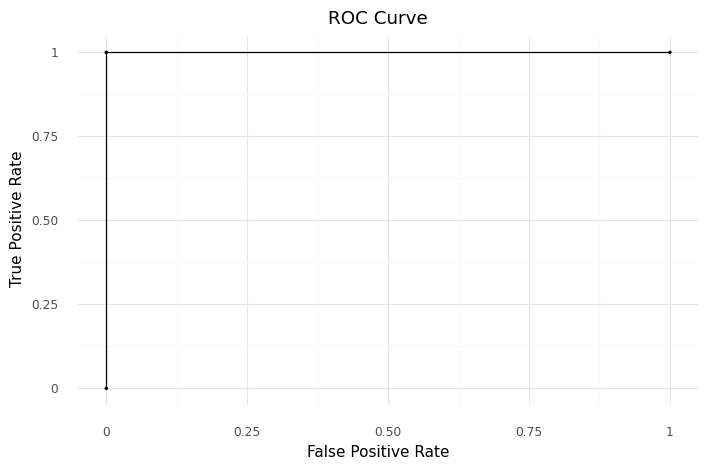

<ggplot: (8757244453693)>

In [ ]:
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
df_fpr_tpr.head()

plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate')+
    ylab('True Positive Rate')+
    theme_minimal()
)

Best Threshold: 1 with G-Mean: 1.0
FPR: 0.0, TPR: 1.0


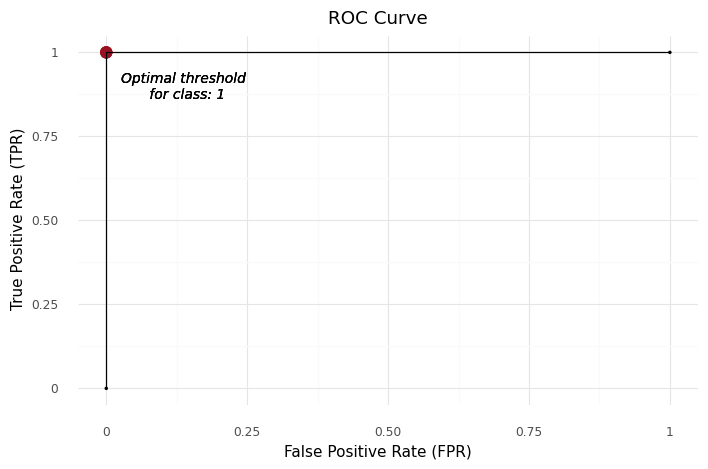

<ggplot: (8757253157237)>

In [ ]:
# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)